In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [3]:
time_window = 25
time_step = 25
trial_bin_size = 20
n_splits = 1000
group_dict = OrderedDict([('1 (hashtag)',[12]),('1 (letter)',[13]),('Set size 2',[20])])
train_labels = ['1 (hashtag)','Set size 2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [6]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

interp = eeg_decoder.Interpreter(clfr, subtitle='h1v2_all')
interp.save_results(timestamp=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [5]:
interp = eeg_decoder.Interpreter(clfr, subtitle='h1v2_all')
interp.load_results('h1v2_all')

0
Significant timepoints: [160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568
 592 664 856 904 928 952]
0
Significant timepoints: [136 160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544
 568 592 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952 976]


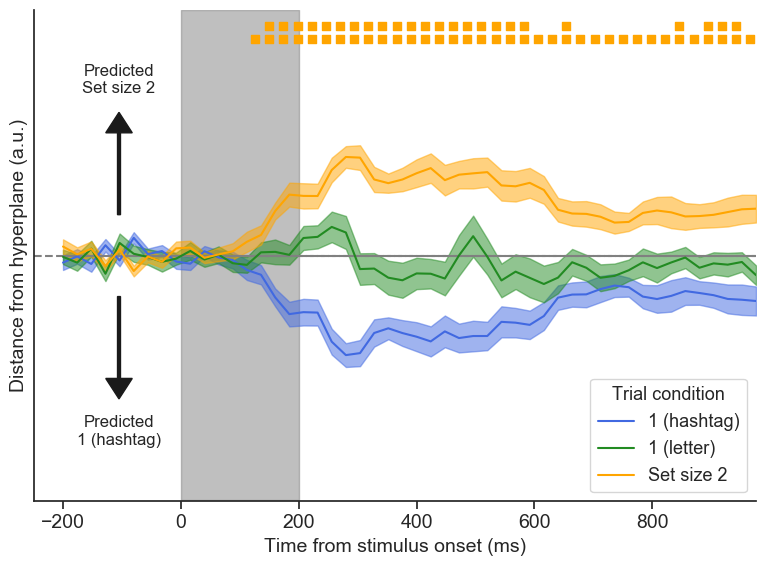

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close()

sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))
interp.colors = ['royalblue', 'forestgreen', 'orange','firebrick']
interp.plot_hyperplane(
    significance_testing_pair=[(0,1),(0,2)],sig_y=2.8, stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
    savefig=False,subtitle='')

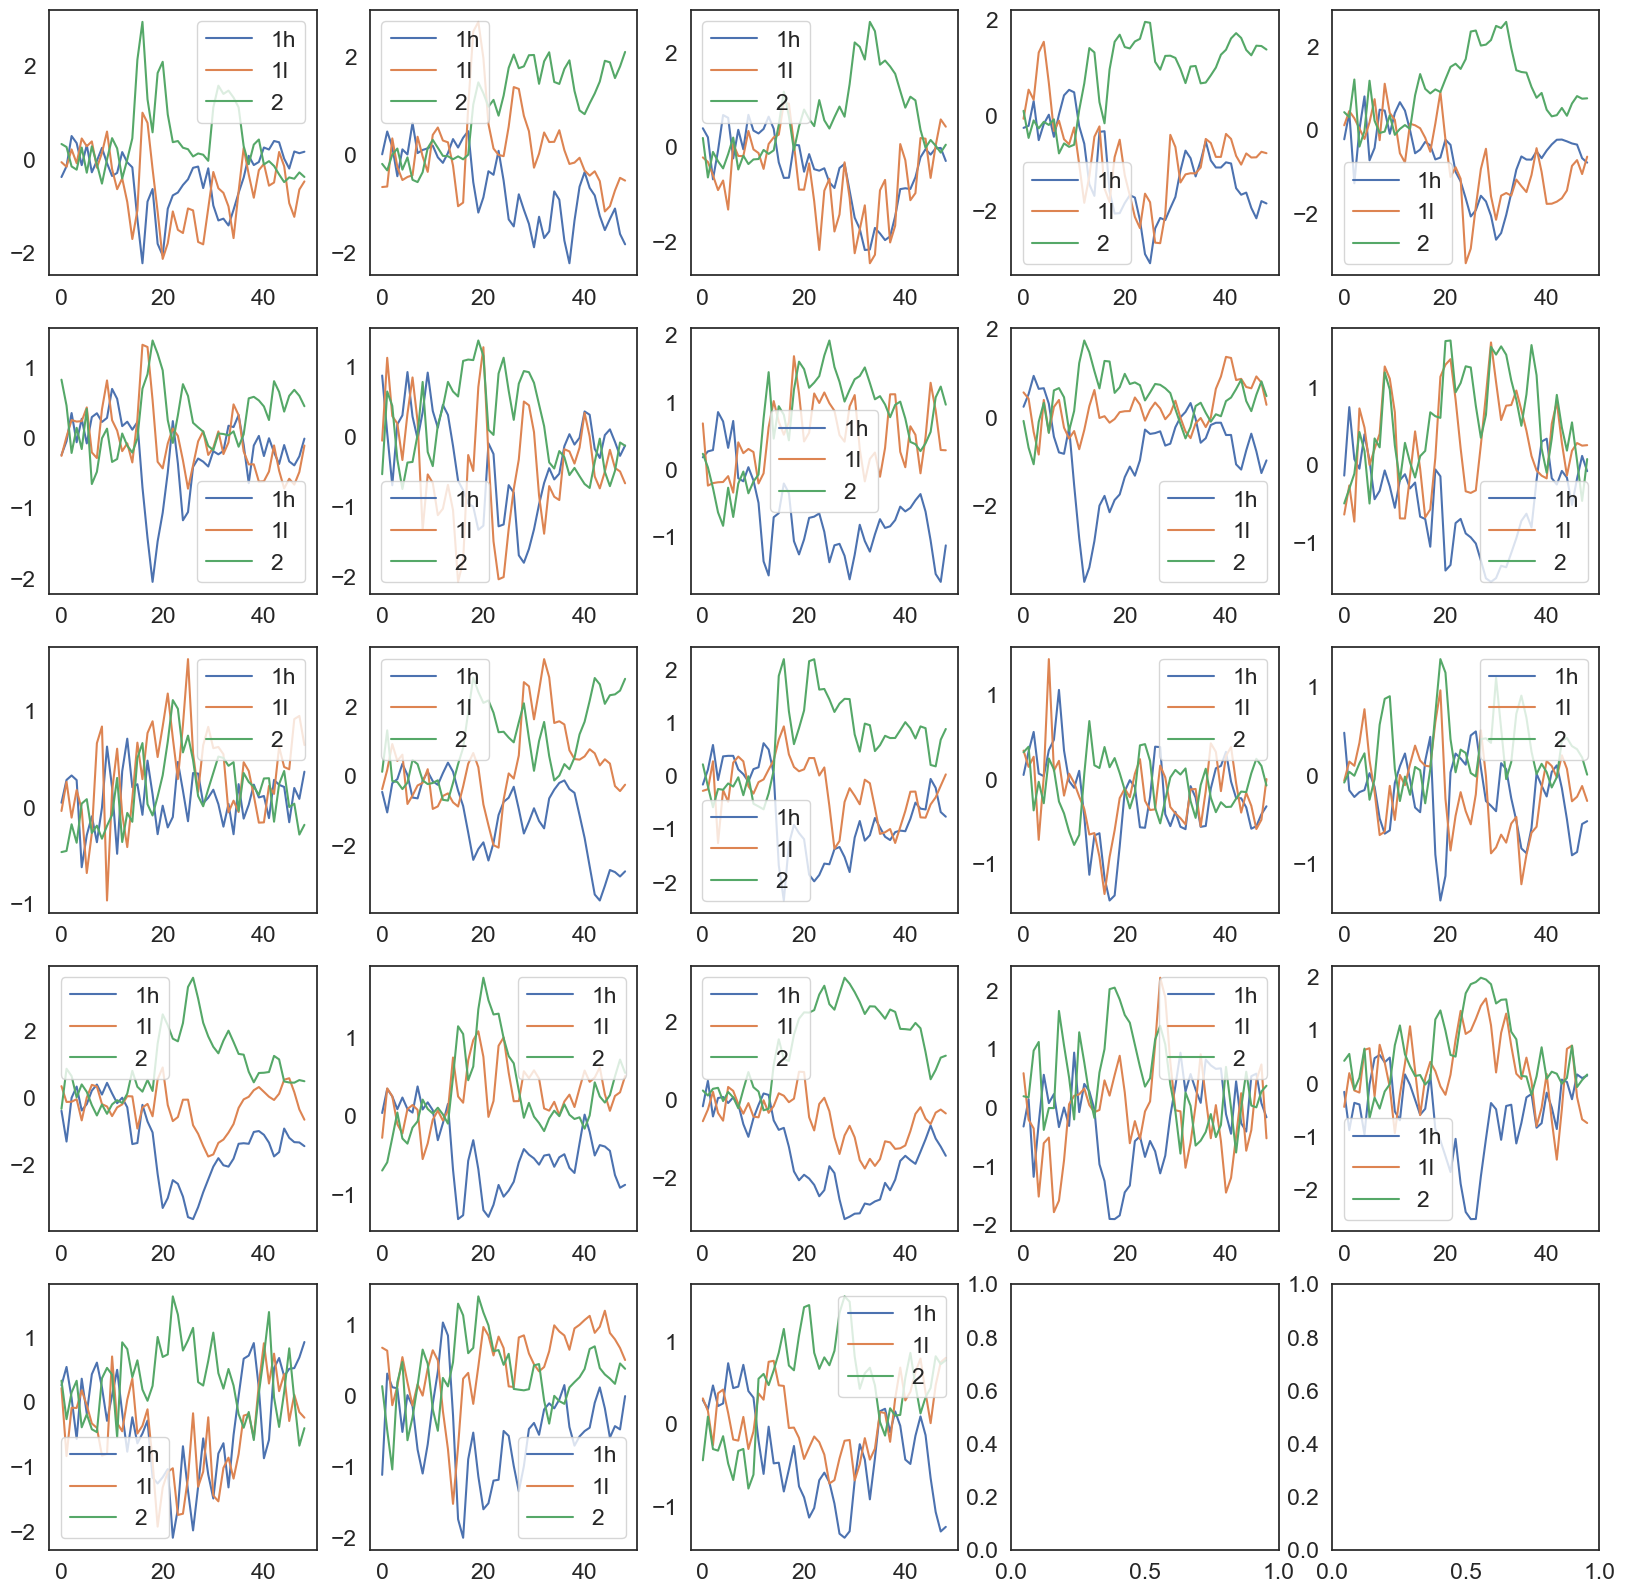

In [7]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(5,5,figsize=(20,20))
for i in range(exp.nsub):
    ax = axes.flat[i]
    v = np.mean(interp.confidence_scores,2)[i]
    ax.plot(v)
    ax.legend(labels=['1h','1l','2'])
plt.show()

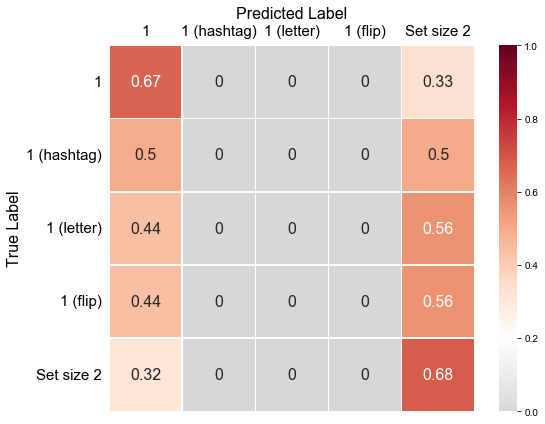

In [ ]:
plt.subplots(figsize=(8,6))
interp.plot_confusion_matrix()

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
means = np.mean(np.mean(interp.confidence_scores,2)[:,(interp.t<1000)&(interp.t>250)],1)


In [102]:
df = pd.DataFrame(means,columns=interp.labels)

<module 'matplotlib.pyplot' from 'c:\\Users\\William\\Anaconda3\\envs\\archery\\lib\\site-packages\\matplotlib\\pyplot.py'>

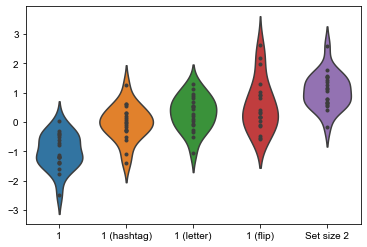

In [103]:
sns.violinplot(data=df,inner='points')
plt

In [104]:
import scipy.stats as sista

In [105]:
sista.ttest_rel(df['1 (hashtag)'],df['1 (letter)'])

Ttest_relResult(statistic=-2.5063659150117266, pvalue=0.021450492814633654)

In [106]:
sista.ttest_rel(df['1 (flip)'],df['1 (letter)'])

Ttest_relResult(statistic=1.4828459252174933, pvalue=0.1545132659406723)